# Introduction aux réseaux de neurones convolutifs

Les réseaux de neurones convolutifs ont prouvé leur utilité en vision par ordinateur. Ce sont des outils puissants pour extraire automatiquement des caractéristiques pertinentes à partir de données structurées telles que les images.

Les éléments-clés d'un réseaux de neurones convolutif sont les **couches de convolution** (*convolutional layers*) et les **couches de regroupement** (*pooling layers*).
Dans ce court tutoriel, nous allons illustrer ces deux types de couches.

Mais nous allons tout d'abord évoquer les **canaux** (*channels*).

> **Remarque** : Certaines des illustrations utilisées dans ce tutoriel proviennent de ce [dépôt GitHub](https://github.com/vdumoulin/conv_arithmetic/) et du [papier associé](https://arxiv.org/pdf/1603.07285.pdf).

## Canaux

Bien que les images 2d soient visuellement en deux dimensions, elles sont en fait généralement en *trois dimensions*. La dimension additionnelle correspond aux **canaux**. Le type d'images le plus courant, les images en couleur, ont 3 canaux : un pour le rouge, un pour le vert et un pour le bleu. De telles images sont couramment appelées *images RGB* en anglais.

> **Remarque** : Certaines images en couleur peuvent avoir 4 canaux, le canal additionnel correspondant à la *transparence*. De telles images sont couramment appelées *images RGBA* en anglais (le A signifiant alpha, qui est le nom de variable couramment utilisé pour la transparence). Nous n'utiliserons pas d'images RGBA dans ces travaux pratiques.

> **Remarque** : Les images en noir et blanc et les images en nuances de gris n'ont qu'un seul canal.

Chargeons une image en couleur :

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def load_rgb_image(path='data'):
    """Load an RGB image.

    Parameters
    ----------
    path : str
        Path to the directory.

    Returns
    -------
    img : array, shape = (960, 1280, 3)
        RGB image.

    """
    import os
    from PIL import Image

    file = os.path.join(path, 'stray.png')

    if not os.path.isfile(file):
        from urllib.request import urlretrieve

        if not os.path.exists(path):
            os.makedirs(path)

        url = (
            'https://raw.githubusercontent.com/johannfaouzi/'
            'apprentissage-profond-ensea-2025/main/figures/stray.png'
        )
        urlretrieve(url, file)

    with Image.open(file) as im:
        img = np.asarray(im)

    plt.imshow(img)
    plt.xticks([]); plt.yticks([]);
    plt.title('RGB image')

    return img

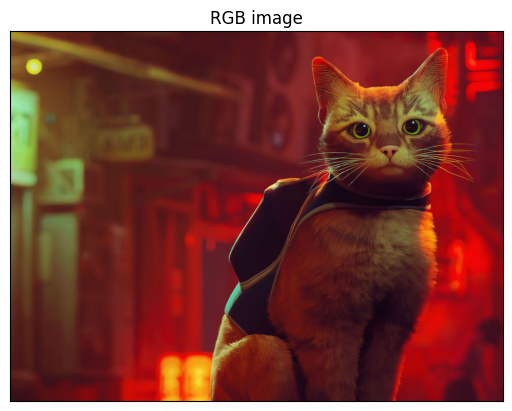

In [5]:
img = load_rgb_image()

In [6]:
print(f"Taille de l'image = {img.shape}")

Taille de l'image = (960, 1280, 3)


On voit bien que l'image a 3 dimensions :

* La première dimension correspond à la hauteur de l'image (le nombre de lignes).
* La deuxième dimension correspond à la largeur de l'image (le nombre de colonnes).
* La troisième dimension correspond aux canaux de couleurs de l'image.

On va afficher les trois canaux de couleurs de l'image. Pour les afficher comme des images en couleur avec la fonction [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), chaque image doit toujours être en trois dimension : il faut remplacer les matrices des autres canaux par des matrices nulles.

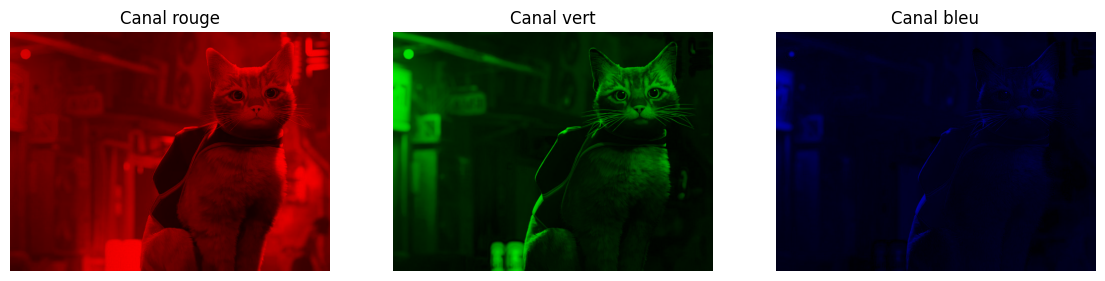

In [7]:
# Canal rouge
img_r = img.copy()
img_r[:, :, 1:] = 0

# Canal vert
img_g = img.copy()
img_g[:, :, 0::2] = 0

# Canal bleu
img_b = img.copy()
img_b[:, :, :2] = 0

# Visualisation
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_r)
plt.title('Canal rouge')
plt.axis('off');

plt.subplot(1, 3, 2)
plt.imshow(img_g)
plt.title('Canal vert')
plt.axis('off');

plt.subplot(1, 3, 3)
plt.imshow(img_b)
plt.title('Canal bleu')
plt.axis('off');

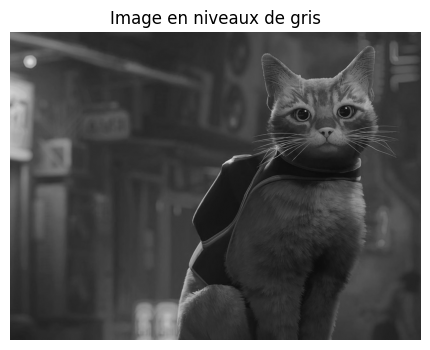

In [10]:
img_black_white = np.mean(img, axis=2)

plt.figure(figsize=(14, 4))
plt.imshow(img_black_white, cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off');

## Convolution

L'idée principale d'une couche de convolution est d'extraire des caractéristiques locales dans un canal. La sortie est également un canal, généralement appelée **carte de caractéristiques** (*feature map*) ou **carte d'activation** (*activation map*).

> **Remarque** : Dans toutes les illustrations ci-dessous, les cartes bleues correspondent à l'entrée et les cartes vertes correspondent à la sortie. Il n'y a qu'une seul canal en entrée et qu'un seul canal en sortie.


### Opération de convolution

Le composant principale de la convolution est l'[opération de convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution) ou [corrélation croisée](https://en.wikipedia.org/wiki/Cross-correlation). En deux dimensions, la corrélation croisée est définie par :
$$
    (H \ast W)_{i,j} = \sum_{k=1}^{M_{\text{ker}}} \sum_{l=1}^{N_{\text{ker}}} H_{i+k,j+l} W_{k,l}
$$

Le canal en sortie est définie comme la somme élément par élément des corrélations croisées plus un biais :
$$
    W^{[k+1]} = \mathbf{b} + \sum_{k=0}^{C_{in} - 1} (H^{[k]} \star W^{[k]})
$$

L'image ci-dessous illustre l'opération de convolution avec un canal en entrée de taille `(4, 4)` et noyau de taille `(3, 3)`, aboutissant à un canal en sortie de taile `(2, 2)` :

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)


### Rembourrage (*padding*)

Le rembourrage consiste à ajouter des éléments supplémentaires, généralement des zéros, aux bords de l'entrée. Sans rembourrage, la sortie est plus petite que l'entrée et les éléments aux bords sont moins utilisés que les autres éléments (sauf avec un noyau de taille 1). Le rembourrage permet de traiter ces phénomènes.

* Avec le semi-rembourrage (*half-padding*, `padding = 'same'`) la sortie a la même taille que l'entrée, mais les éléments de l'entrée aux bords restent toujours moins utilisés que les autres éléments.

* Avec le rembourrage complet (*full padding*, `padding = kernel_size`), la sortie est de plus grande taille que l'entrée, mais tous les éléments de l'entrée sont autant utilisés les uns que les autres).

L'image ci-dessous illustre le demi-rembourrage :

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)


### Pas (*stride*)

Le pas détermine le pas du noyau parcourant l'entrée. Utiliser des pas élevés (> 1) est une manière de faire du sous-échantillonage : seul un sous-ensemble de régions sera convolué parmi toutes les régions possibles.

L'image ci-dessous illustre la notion de foulée avec `stride = 2` :

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif)


### Dilatation (*dilation*)

La dilatation consiste à ne prendre qu'un élément tous les *k* éléments selon une dimension. Cette technique permet d'avoir un champ de vision plus large sans augmenter la taille du noyau, mais au prix d'un sous-échantillonage. Cette approche peut également être utile pour diminuer la taille des cartes de caractéirsitques.

L'image ci-dessous illustre la dilatation avec `dilation = 2` :

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif)

### Noyaux

L'intérêt des réseaux de neurones convolutifs est de les laisser apprendre les noyaux utiles pour la tâche d'apprentissage automatique considérée à partir des données fournies. Néanmoins, certains noyaux sont déjà bien connus dans le domaine du traitement d'images. Par exemple, cette [page Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing)) met en avant quelques noyaux. À titre illustratif, nous utiliserons ces noyaux dans ce tutoriel.

La fonction `convolve_and_plot` définie ci-desosus permet de convoluer une image avec un noyau donné et de comparer l'image originale avec l'image convoluée :

In [41]:
import torch


def convolve_and_plot(img, kernel, use_scipy=False, **kwargs):
    """Convolve and plot an image.

    Parameters
    ----------
    img : array, shape = (width, height, n_channels)
        Image.

    kernel : list[list], array or Tensor, shape = (height, width)
        Kernel.

    use_scipy : bool (default = False)
        If True, the convolution operation is performed using
        scipy.signal.fftconvolve, which is considerably faster
        for large kernels.

    kwargs
        Other keyword arguments provided to either
        torch.nn.Conv2d or scipy.signal.fftconvolve.

    """

    if use_scipy:
        from scipy.signal import fftconvolve

        # If not provided, add padding so that the output has the same shape as the input
        if "mode" not in kwargs.keys():
            print('here')
            kwargs["mode"] = "same"

        img_convolved = np.array([
            fftconvolve(img[:, :, i] / 255, kernel, **kwargs) for i in range(3)
        ])

    else:
        # If not provided, add padding so that the output has the same shape as the input
        if "padding" not in kwargs.keys():
            kwargs["padding"] = "same"

        # If not provided, do not add bias after the convolution
        if "bias" not in kwargs.keys():
            kwargs["bias"] = False

        conv = torch.nn.Conv2d(3, 3, len(kernel), groups=3, **kwargs)

        # Update the weights of the kernel with the given kernel
        if isinstance(kernel, list):
            kern = torch.tensor(kernel, dtype=torch.float32)
        elif isinstance(kernel, np.ndarray):
            kern = torch.from_numpy(kernel).to(dtype=torch.float32)
        elif isinstance(kernel, torch.Tensor):
            kern = kernel.to(dtype=torch.float32)
        else:
            raise ValueError("'kernel' is poorly formatted.")

        if not len(kern.shape) == 2:
            raise ValueError("'kernel' must be two-dimensional.")
        conv.weight = torch.nn.Parameter(kern.repeat(3, 1, 1, 1), requires_grad=False)

        # Perform the convolution
        img_convolved = conv(
            (torch.from_numpy(np.transpose(img.astype("float32") / 255, (2, 0, 1))))
        ).numpy()

    img_convolved = np.transpose(np.clip(img_convolved, 0., 1.), (1, 2, 0))

    # Plot the original and convolved images
    plt.figure(figsize=(13, 4.8))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([]);
    plt.title("Image originale");

    plt.subplot(1, 2, 2)
    plt.imshow(img_convolved)
    plt.xticks([]); plt.yticks([]);
    plt.title("Image convoluée");
    plt.title("test")
    print(f"Taille de l'image = {img_convolved.shape}")

### Exercice 2

On va afficher des images convoluées en utilisant la fonction `convolve_and_plot` définie ci-dessus et des noyaux définis dans cette [page Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing)). Vous trouverez également la documentation de la classe [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) pour une description complète des hyperparamètres de l'opération de convolution.

> **Remarque** : Dans cet exemple, le même noyau en 2d est appliqué à tous les canaux en entrée (les canaux de couleurs). En pratique, le modèle apprend des noyaux spécifiques pour chaque paire (canal en entrée, canal en sortie).

> **Remarque** : Si vous utilisez des noyaux de grande taille avec les valeurs par défaut pour la foulée (*stride*) et la dilatation (*dilation*), il vaut peut-être mieux utiliser l'opération de convolution implémentée dans la fonction [`scipy.signal.convolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) : cela devrait être plus rapide et utiliser beaucoup moins de mémoire. C'est pertinent pour les noyaux de floutage et de renforcement de netteté qui nécessitent d'être de grande taille pour voir leur effet car l'image est en haute résolution. Pour ce faire, il suffit de changer la valeur de l'argument `use_scipy` en `True`.

> **Remarque** : Le code ci-dessous vous permet de générer des noyaux de floutage gaussien et de renforcement de netteté de taille impaire.

In [32]:
def gaussian_blur_kernel(kernel_size, sigma=10.):
    """Génère un noyau de floutage gaussien.

    Parameters
    ----------
    kernel_size : int
        Taille du noyau. Doit être un entier impair supérieur ou égal à 3.

    sigma : float (default = 10.)
        Écart-type de la distribution gaussienne. Plus la valeur est élevée,
        plus l'image en sortie est floue.

    Returns
    -------
    kernel : array, shape = (kernel_size, kernel_size)
        Noyau de floutage gaussien.

    """
    from scipy.stats import multivariate_normal

    if not (isinstance(kernel_size, int) and (kernel_size > 2) and (kernel_size % 2 == 1)):
        raise ValueError("'kernel_size' doit être un entier impair supérieur ou égal à 3.")

    if not sigma > 0:
        raise ValueError("'sigma' doit être strictement positif.")

    size = (kernel_size - 1) // 2

    x = np.asarray([[
        [i, j] for i in range(-size, size + 1)] for j in range(-size, size + 1)
    ])

    kernel = multivariate_normal.pdf(x, cov=np.diag([sigma ** 2] * 2))

    return kernel / kernel.sum()


def unsharp_masking_kernel(kernel_size, sigma=10.):
    """Génère le noyau de masque flou basé sur le floutage gaussien.

    Parameters
    ----------
    kernel_size : int
        Taille du noyau. Doit être un entier impair supérieur ou égal à 3.

    sigma : float (default = 10.)
        Écart-type de la distribution gaussienne. Plus la valeur est élevée,
        plus l'image en sortie est floue.

    Returns
    -------
    kernel : array, shape = (kernel_size, kernel_size)
        Noyau de masque flou.

    """
    kernel = gaussian_blur_kernel(kernel_size, sigma)

    # From Gaussian blur to unsharp masking
    size = (kernel_size - 1) // 2
    kernel *= -1.
    kernel[size, size] += 2.

    return kernel

Taille de l'image = (958, 1278, 3)


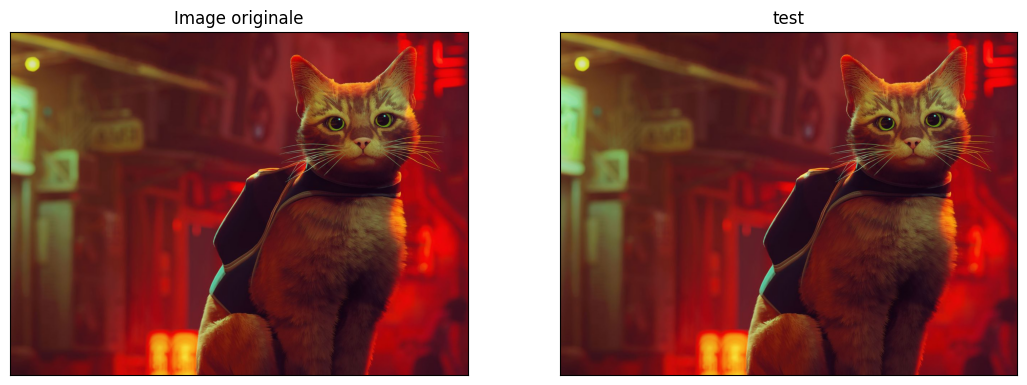

In [42]:
identity_kernel = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

convolve_and_plot(img, identity_kernel)


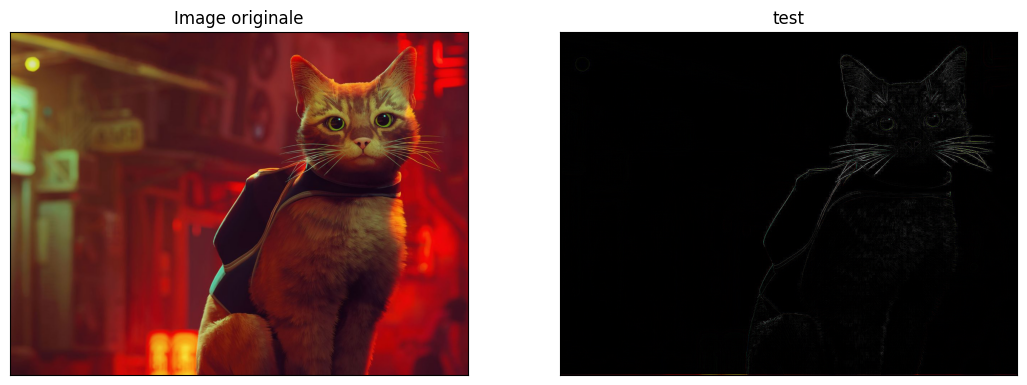

In [19]:
ridge_kernel = [
    [+0, -1, +0],
    [-1, +4, -1],
    [+0, -1, +0]
]

convolve_and_plot(img, ridge_kernel)

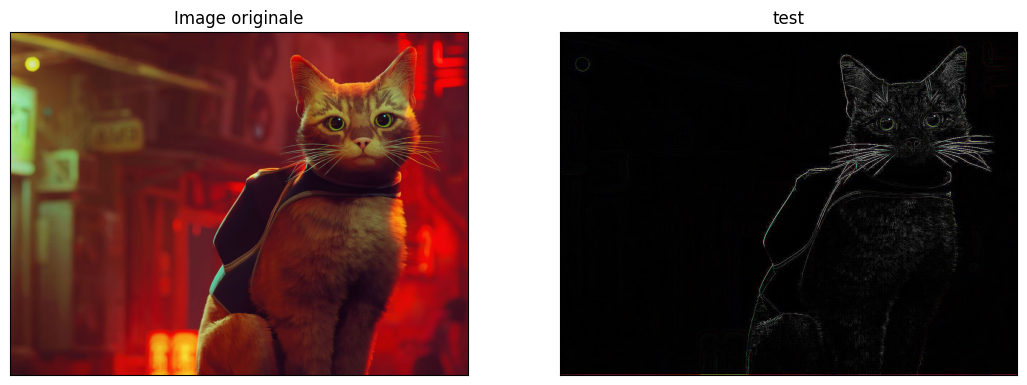

In [20]:
edge_kernel = [
    [-1, -1, -1],
    [-1, +8, -1],
    [-1, -1, -1]
]

convolve_and_plot(img, edge_kernel)

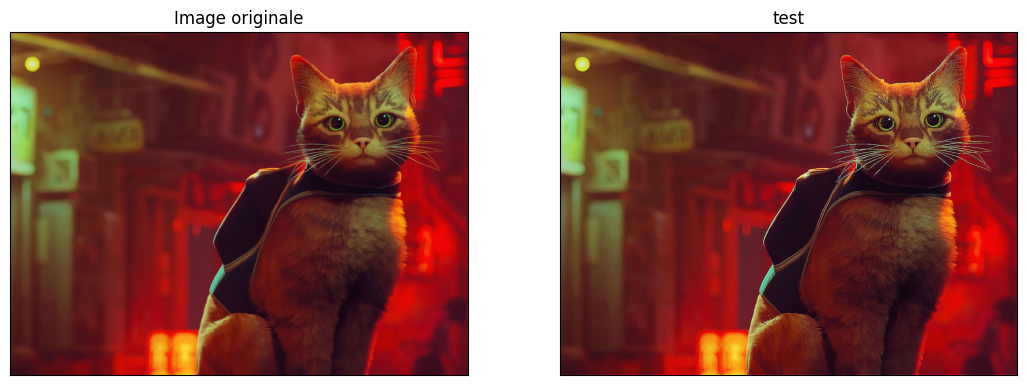

In [21]:
sharpen_kernel = [
    [+0, -1, +0],
    [-1, +5, -1],
    [+0, -1, +0]
]

convolve_and_plot(img, sharpen_kernel)

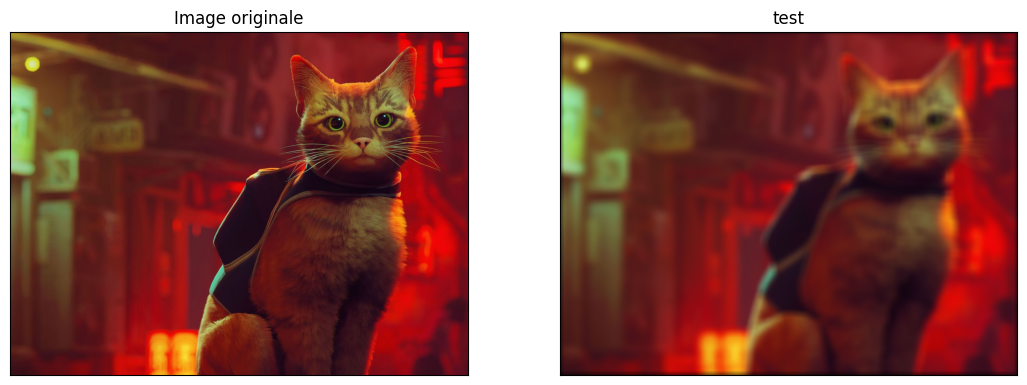

In [22]:
box_blur_kernel = np.full((25, 25), 1 / 625)

convolve_and_plot(img, box_blur_kernel, use_scipy=True)

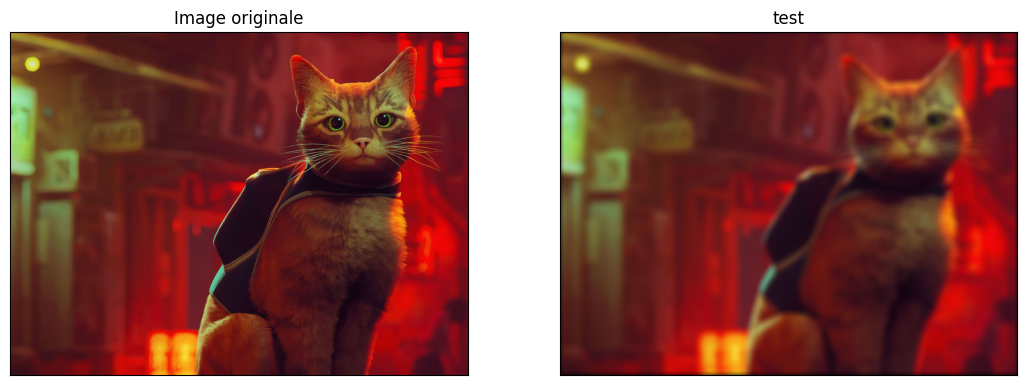

In [23]:
convolve_and_plot(img, gaussian_blur_kernel(25, sigma=10.), use_scipy=True)

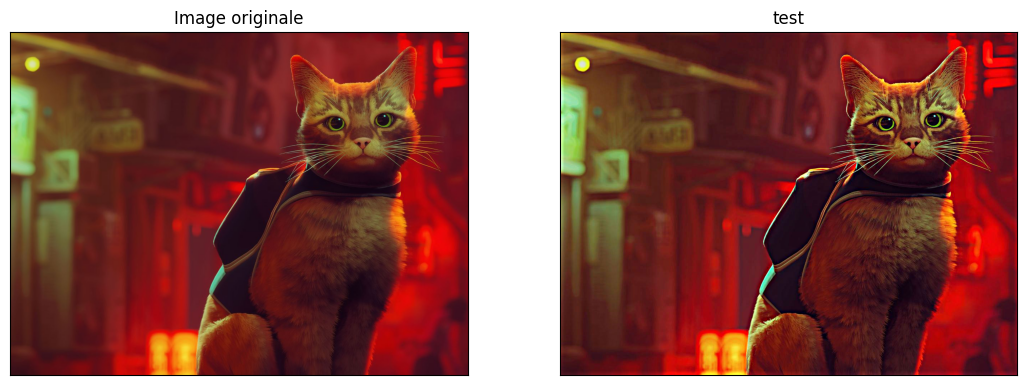

In [24]:
convolve_and_plot(img, unsharp_masking_kernel(25, sigma=10.), use_scipy=True)

## Regroupement (*pooling*)

L'opération de regroupement permet de réduire la taille des cartes de caractéristiques en appliquant une fonction de réduction dans les différentes zones des cartes.

L'opération de regroupement consiste à faire glisser une fenêtre le long de l'entrée et d'appliquer une fonction de réduction à l'intérieur de chaque fenêtre, généralement le maximum ou la moyenne.

L'image ci-dessous illustre l'opération de regroupement avec un noyau de taille `2 x 2` et la fonction maximum.

![](https://github.com/Bapt1st3/ensai-apprentissage-profond/blob/main/figures/max_pooling.gif?raw=1)

La fonction `pool_and_plot` définie ci-dessous permet d'effectuer une opération de regroupement sur une image et de comparer l'image originale avec l'image obtenue :

In [25]:
def pool_and_plot(img, pooling='max', kernel_size=1, **kwargs):
    """Pool and plot an image.

    Parameters
    ----------
    img : array, shape = (width, height, n_channels)
        Image.

    pooling : {'max', 'average'} (default = 'max')
        Type de regroupement. Doit être soit 'max' soit 'average'.

    kernel_size : int (default = 1)
        Taille du noyau.

    kwargs
        Autres arguments fournis soit à torch.nn.MaxPool2d ou torch.nn.AvgPool2d.

    """
    from torch import nn

    if pooling == 'max':
        pool = nn.MaxPool2d(kernel_size=kernel_size, **kwargs)
    elif pooling == 'average':
        pool = nn.AvgPool2d(kernel_size=kernel_size, **kwargs)
    else:
        raise ValueError("'pooling' doit être soit 'max' soit 'average'.")


    img_pooled = np.transpose(pool(
        (torch.from_numpy(np.transpose(img.astype('float64') / 255, (2, 0, 1))))
    ).numpy(), (1, 2, 0))

    # Plot the original and pooled images
    plt.figure(figsize=(13, 4.8))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([]);
    plt.title('Image originale');

    plt.subplot(1, 2, 2)
    plt.imshow(img_pooled)
    plt.xticks([]); plt.yticks([]);
    plt.title(f"Image regroupée par {'le maximum' if pooling == 'max' else 'la moyenne'}\n"
              f"avec un noyau de taille {kernel_size}");

On va afficher des images regroupées en utilisant la fonction `pool_and_plot` avec différentes valeurs pour les hyperparamètres. Vous pouvez lire la documentation des classes [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) et [`torch.nn.AvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) pour une description complète des hyperparamètres. En particulier, comparez les résultats des regroupements avec le maximum et la moyenne.

> **Remarque : L'image regroupée est de plus petite taille que l'image originale. La fonction affiche les deux images avec la même taille, mais l'image regroupée est de plus faible résolution que l'image originale.**

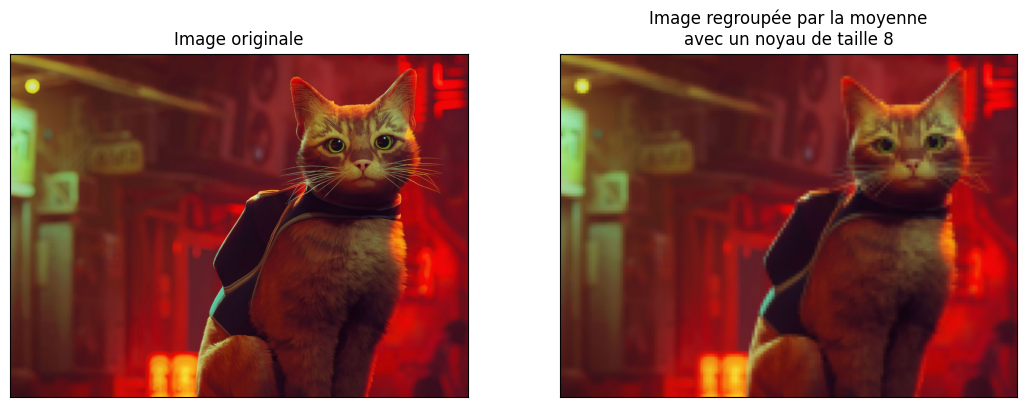

In [26]:
pool_and_plot(img, pooling='average', kernel_size=8)

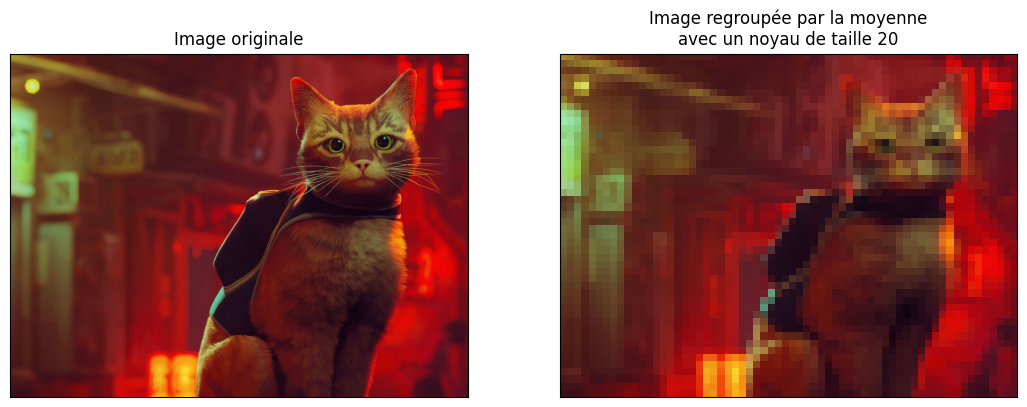

In [27]:
pool_and_plot(img, pooling='average', kernel_size=20)

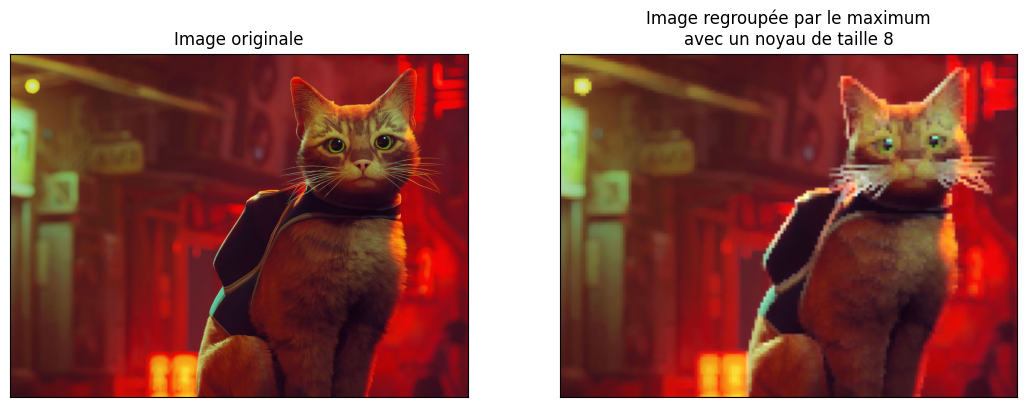

In [28]:
pool_and_plot(img, pooling='max', kernel_size=8)

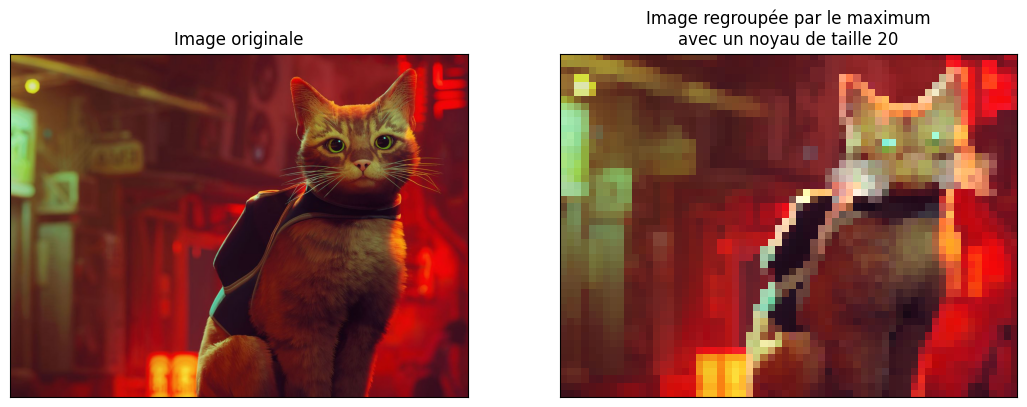

In [29]:
pool_and_plot(img, pooling='max', kernel_size=20)